# Climate Change Tweet Classification using an SVM

In [1]:
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse

from discourseparse import DiscourseParsing
from emonal import Emo

In [2]:
with open("../data/tweets.txt","r",encoding="utf-8") as f:
    tweets = f.readlines()
with open("../data/labels.csv","r",encoding="utf-8") as f:
    labels = f.readlines()

In [3]:
y_data = pd.Series([x.strip() for x in labels])

In [4]:
tkznr = TweetTokenizer(reduce_len=True)
def twokenize(text:str):
    return tkznr.tokenize(text)
    
vectorizer_uni = CountVectorizer(tokenizer=twokenize,analyzer='word')
vectorizer_unibi = CountVectorizer(tokenizer=twokenize,analyzer='word',ngram_range=(1,2))

vectorizer_unigram = TfidfVectorizer(tokenizer=twokenize,analyzer='word')
vectorizer_unibigram = TfidfVectorizer(tokenizer=twokenize,analyzer='word',ngram_range=(1,2))
vectorizer_char34gram = TfidfVectorizer(analyzer='char',ngram_range=(3,4))
vectorizer_char45gram = TfidfVectorizer(analyzer='char',ngram_range=(4,5))

## Bag-of-Words Word-level Unigrams

In [5]:
x_data = vectorizer_uni.fit_transform(tweets)
x_data.shape

(1999, 4921)

In [6]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter Tuning

In [7]:
uni_clf = svm.LinearSVC()
uni_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
uni_grid = model_selection.GridSearchCV(uni_clf,param_grid=uni_parameters,scoring="f1_weighted",refit=True,cv=5)
uni_grid.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [8]:
uni_grid_df = pd.DataFrame(uni_grid.cv_results_)
uni_grid.best_params_

{'C': 0.1}

### Evaluation

In [9]:
y_uni = uni_grid.predict(x_test)

In [10]:
sns_conf = metrics.confusion_matrix(y_test,y_uni,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

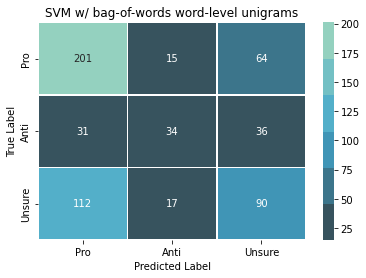

In [11]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ bag-of-words word-level unigrams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [12]:
accuracy = metrics.accuracy_score(y_test,y_uni)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_uni,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.5416666666666666
Precision: 0.5322863271639282
Recall: 0.5416666666666666
F1 Score: 0.5298196366341983



## Bag-of-Words Word-level Uni- and Bigrams

In [13]:
x_data = vectorizer_unibi.fit_transform(tweets)
x_data.shape

(1999, 22407)

In [14]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter Tuning

In [15]:
unibi_clf = svm.LinearSVC()
unibi_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
unibi_grid = model_selection.GridSearchCV(unibi_clf,param_grid=unibi_parameters,scoring="f1_weighted",refit=True,cv=5)
unibi_grid.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [16]:
unibi_grid_df = pd.DataFrame(unibi_grid.cv_results_)
unibi_grid.best_params_

{'C': 0.1}

### Evaluation

In [17]:
y_unibi = unibi_grid.predict(x_test)

In [18]:
sns_conf = metrics.confusion_matrix(y_test,y_unibi,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

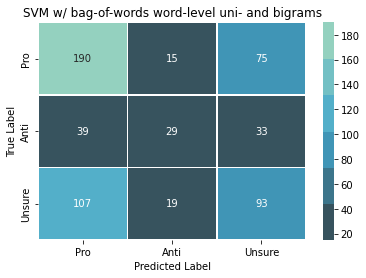

In [19]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ bag-of-words word-level uni- and bigrams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [20]:
accuracy = metrics.accuracy_score(y_test,y_unibi)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_unibi,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.52
Precision: 0.5102562583905867
Recall: 0.52
F1 Score: 0.5090541653468483



## Tf-idf Word-level Unigrams

In [21]:
x_data = vectorizer_unigram.fit_transform(tweets)
x_data.shape

(1999, 4921)

In [22]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter-Tuning

In [23]:
unigram_clf = svm.LinearSVC()
unigram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
unigram_grid = model_selection.GridSearchCV(unigram_clf,param_grid=unigram_parameters,scoring='f1_weighted',refit=True,cv=5)
unigram_grid.fit(x_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [24]:
unigram_grid_df = pd.DataFrame(unigram_grid.cv_results_)
unigram_grid.best_params_

{'C': 10}

### Evaluation

In [25]:
y_unigram = unigram_grid.predict(x_test)

In [26]:
sns_conf = metrics.confusion_matrix(y_test,y_unigram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

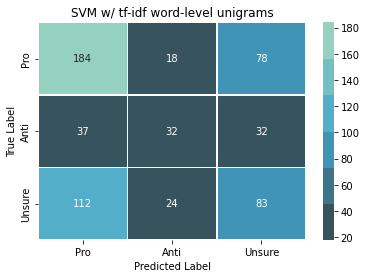

In [27]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ tf-idf word-level unigrams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [28]:
accuracy = metrics.accuracy_score(y_test,y_unigram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_unigram,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.49833333333333335
Precision: 0.4876195625677491
Recall: 0.49833333333333335
F1 Score: 0.4887772682192502



## Tf-idf Word-Level Uni- and Bigrams

In [71]:
x_data = vectorizer_unibigram.fit_transform(tweets)
x_data.shape

(1999, 22407)

In [72]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter-Tuning

In [73]:
unibigram_clf = svm.LinearSVC()
unibigram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
unibigram_grid = model_selection.GridSearchCV(unibigram_clf,param_grid=unibigram_parameters,scoring='f1_weighted',refit=True,cv=5)
unibigram_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [74]:
unibigram_grid_df = pd.DataFrame(unibigram_grid.cv_results_)
unibigram_grid.best_params_

{'C': 10}

### Evaluation

In [75]:
y_unibigram = unibigram_grid.predict(x_test)

In [76]:
sns_conf = metrics.confusion_matrix(y_test,y_unibigram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

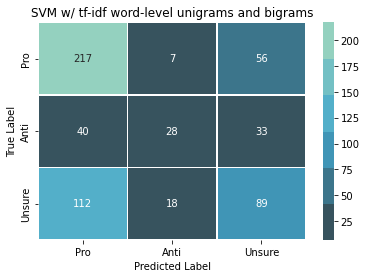

In [77]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ tf-idf word-level unigrams and bigrams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [78]:
accuracy = metrics.accuracy_score(y_test,y_unigram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_unibigram,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.49833333333333335
Precision: 0.5458662286308398
Recall: 0.5566666666666666
F1 Score: 0.5369343652121263



## Character-Level Tri- and 4-grams

In [37]:
x_data = vectorizer_char34gram.fit_transform(tweets)
x_data.shape

(1999, 27204)

In [38]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter-Tuning

In [39]:
char34gram_clf = svm.LinearSVC()
char34gram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
char34gram_grid = model_selection.GridSearchCV(char34gram_clf,param_grid=char34gram_parameters,scoring='f1_weighted',refit=True,cv=5)
char34gram_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [40]:
char34gram_grid_df = pd.DataFrame(char34gram_grid.cv_results_)
char34gram_grid.best_params_

{'C': 10}

### Evaluation

In [41]:
y_char34gram = char34gram_grid.predict(x_test)

In [42]:
sns_conf = metrics.confusion_matrix(y_test,y_char34gram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

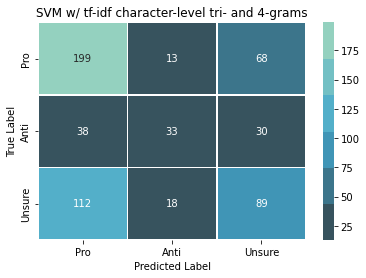

In [43]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ tf-idf character-level tri- and 4-grams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [44]:
accuracy = metrics.accuracy_score(y_test,y_char34gram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_char34gram,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.535
Precision: 0.5266070533041948
Recall: 0.535
F1 Score: 0.5226414826881357



## Character-Level 4- and 5-grams

In [45]:
x_data = vectorizer_char45gram.fit_transform(tweets)
x_data.shape

(1999, 61190)

In [46]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter-Tuning

In [47]:
char45gram_clf = svm.LinearSVC()
char45gram_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
char45gram_grid = model_selection.GridSearchCV(char45gram_clf,param_grid=char45gram_parameters,scoring='f1_weighted',refit=True,cv=5)
char45gram_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [48]:
char45gram_grid_df = pd.DataFrame(char45gram_grid.cv_results_)
char45gram_grid.best_params_

{'C': 1}

### Evaluation

In [49]:
y_char45gram = char45gram_grid.predict(x_test)

In [50]:
sns_conf = metrics.confusion_matrix(y_test,y_char45gram,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

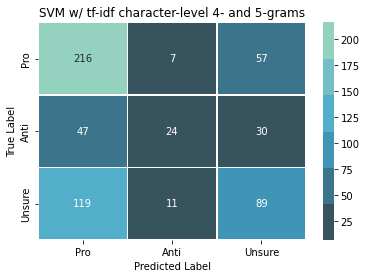

In [51]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ tf-idf character-level 4- and 5-grams",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [52]:
accuracy = metrics.accuracy_score(y_test,y_char45gram)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_char45gram,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.5483333333333333
Precision: 0.5446386853765781
Recall: 0.5483333333333333
F1 Score: 0.525516231216105



# SVM with Discourse Features

In [53]:
discourse_features = DiscourseParsing()
x_data = discourse_features.vectorize(tweets)
x_data.shape

(1999, 16785)

In [54]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter Tuning

In [55]:
disc_clf = svm.LinearSVC()
disc_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
disc_grid = model_selection.GridSearchCV(disc_clf,param_grid=disc_parameters,scoring='f1_weighted',refit=True,cv=5)
disc_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [56]:
disc_grid_df = pd.DataFrame(disc_grid.cv_results_)
disc_grid.best_params_

{'C': 10}

### Evaluation

In [57]:
y_disc =disc_grid.predict(x_test)

In [58]:
sns_conf = metrics.confusion_matrix(y_test,y_disc,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

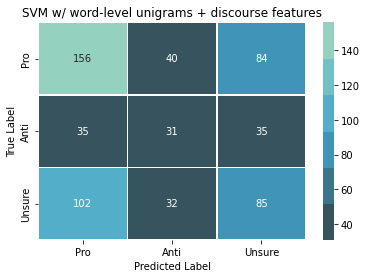

In [59]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ word-level unigrams + discourse features",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [60]:
accuracy = metrics.accuracy_score(y_test,y_disc)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_disc,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.4533333333333333
Precision: 0.45121092757657094
Recall: 0.4533333333333333
F1 Score: 0.4519516596880482



# SVM with Emotion Features

In [61]:
lexipaths = {
    "VAD": "NRC-VAD-Lexicon/NRC-VAD-Lexicon.txt",
    "emotion": "NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    "affect intensity": "NRC-Affect-Intensity-Lexicon/NRC-AffectIntensity-Lexicon.txt"
}
big_folder = "NRC-Sentiment-Emotion-Lexicons"

In [62]:
emo_lists = {
"anger": [],
"anticipation": [],
"disgust": [],
"fear": [],
"joy": [],
"sadness": [],
"surprise": [],
"trust": [],
"Valence": [],
"Arousal": [],
"Dominance": [],
"anger_int": [],
"fear_int": [],
"joy_int": [],
"sadness_int": []
}

emote = Emo(lexipaths,big_folder)
for t in tweets:
    if (emo := emote.classify_sentence(t,"emotion")):
        for k in emo[0]:
            emo_lists[k].append(emo[0][k])
    else:
        for s in {"anger","anticipation","disgust","fear","joy","sadness","surprise","trust"}:
            emo_lists[s].append(0.0)
    if (emo_int := emote.classify_sentence(t,"affect intensity")):
        for k in emo_int[0]:
            k_string = "{}_int".format(k)
            emo_lists[k_string].append(emo_int[0][k])
    else:
        for s in {"anger_int","fear_int","joy_int","sadness_int"}:
            emo_lists[s].append(0.0)
    if (vad := emote.classify_sentence(t,"VAD")):
        for k in vad[0]:
            emo_lists[k].append(vad[0][k])
    else:
        for s in {"Valence","Dominance","Arousal"}:
            emo_lists[s].append(0.0)
    

In [63]:
li = [np.array(emo_lists[x])[:,None] for x in emo_lists]
x_word_data = vectorizer_unibigram.fit_transform(tweets)
x_vect_comb = [x_word_data] + li
x_data = sparse.hstack(x_vect_comb)

In [64]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data,y_data,test_size=0.3,random_state=42)

### Parameter Tuning

In [65]:
emo_clf = svm.LinearSVC()
emo_parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
emo_grid = model_selection.GridSearchCV(emo_clf,param_grid=emo_parameters,scoring='f1_weighted',refit=True,cv=5)
emo_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [66]:
emo_grid_df = pd.DataFrame(emo_grid.cv_results_)
emo_grid.best_params_

{'C': 10}

### Evaluation

In [67]:
y_emo = emo_grid.predict(x_test)

In [68]:
sns_conf = metrics.confusion_matrix(y_test,y_emo,labels=['1','2','3'])
label_11, label_12, label_13, label_21, label_22, label_23, label_31, label_32, label_33 = sns_conf.ravel()
sns_cm = pd.DataFrame(sns_conf,index = ['1','2','3'], columns = ['1','2','3'])
sns_cm.columns = ["Pro", "Anti","Unsure"]
sns_cm.index = ["Pro", "Anti","Unsure"]

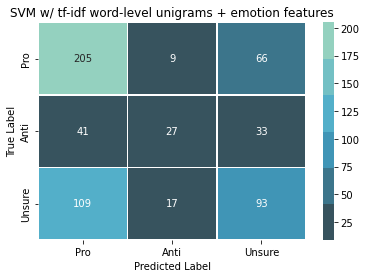

In [69]:
fig, ax = plt.subplots()
heatmap = sns.heatmap(sns_cm, annot=True, fmt="d",ax=ax,linewidths=.5,cmap=sns.color_palette("GnBu_d"))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, va="center")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
ax.set(title="SVM w/ tf-idf word-level unigrams + emotion features",xlabel="Predicted Label",ylabel="True Label")
fig.show()

In [70]:
accuracy = metrics.accuracy_score(y_test,y_emo)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test,y_emo,average='weighted')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n")

Accuracy: 0.5416666666666666
Precision: 0.5320351600562495
Recall: 0.5416666666666666
F1 Score: 0.5255207917358041

